In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digital-currency-time-series/dc.csv


In [2]:
import pandas as pd #для анализа табличных данных
from datetime import timedelta
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List
import seaborn as sns
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
#df = pd.read_csv("../input/amazonstockprice/Amazon.csv")
df = pd.read_csv("../input/digital-currency-time-series/dc.csv").rename( columns={'Unnamed: 0':'date_day'}).rename(str.lower, axis='columns')
date_days = pd.to_datetime(df.pop('date_day'), format='%Y.%m.%d')


In [4]:
#date_days = pd.to_datetime(df.pop('Date'), format='%Y.%m.%d')

In [5]:
df.shape

(1000, 9)

In [6]:
#my_col_name = 'Close'
#my_time_name = 'Date'
my_col_name = 'close_usd'
my_time_name = 'days'
my_plot_cols = ['open_usd', 'high_usd', 'close_usd']

my_width = 24
my_shift = 1

my_conv_width = 3
wide_label_width = 24
wide_input_width = wide_label_width + (my_conv_width - 1)

my_out_steps = 24
OUT_STEPS = 24
CONV_WIDTH = 3
df.head()

#Open - Цена открытия
#High - Самая высокая цена акций
#Low - Самая низкая цена акций
#Close - Цена акции на момент закрытия рынка
#Volume - Объем торгов

,open_sar,open_usd,high_sar,high_usd,low_sar,low_usd,close_sar,close_usd,volume
0,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [7]:
date_days.head(15)

0    2021-01-30
1    2021-01-29
2    2021-01-28
3    2021-01-27
4    2021-01-26
5    2021-01-25
6    2021-01-24
7    2021-01-23
8    2021-01-22
9    2021-01-21
10   2021-01-20
11   2021-01-19
12   2021-01-18
13   2021-01-17
14   2021-01-16
Name: date_day, dtype: datetime64[ns]

In [8]:
date_days.min(), date_days.max()

(Timestamp('2018-05-07 00:00:00'), Timestamp('2021-01-30 00:00:00'))

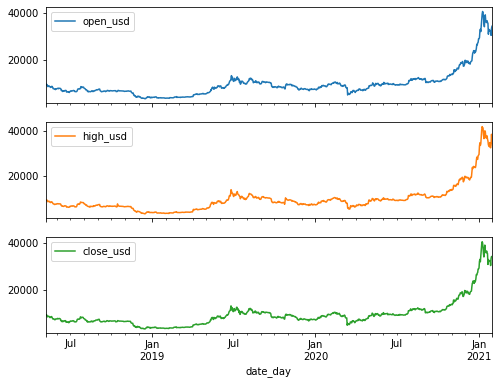

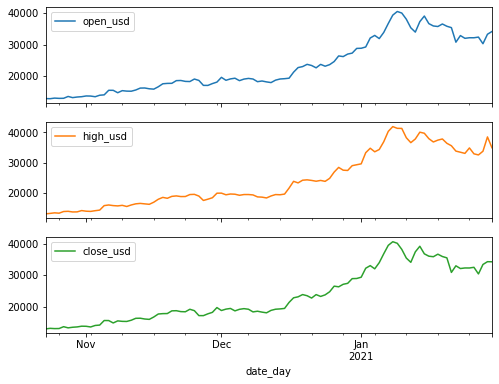

In [9]:
#my_plot_cols = [[my_plot_cols]]
plot_features = df[my_plot_cols]
plot_features.index = date_days
_ = plot_features.plot(subplots=True)

plot_features = df[my_plot_cols][:100]
plot_features.index = date_days[:100]
_ = plot_features.plot(subplots=True)

In [10]:
#df[["Open", "Close", "Low", "High"]].corr() #попарная корреляция между ценами
#все цены зависят друг от друга

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open_sar,1000.0,34825.322255,21728.028028,12045.197184,24254.558752,30714.632128,38317.311744,152217.334784
open_usd,1000.0,9285.762120,5793.522832,3211.710000,6467.192500,8189.695000,10216.860000,40586.960000
high_sar,1000.0,35789.618165,22785.946842,12288.185600,24686.089152,31321.953152,39077.527200,157329.280000
high_usd,1000.0,9542.880270,6075.604427,3276.500000,6582.255000,8351.630000,10419.562500,41950.000000
low_sar,1000.0,33796.329057,20565.410145,11837.237504,23721.336256,30010.869568,37158.878816,145215.488000
low_usd,1000.0,9011.393200,5483.524463,3156.260000,6325.015000,8002.045000,9907.977500,38720.000000
close_sar,1000.0,34917.483572,21928.280072,12045.234688,24252.946080,30713.263232,38329.725568,152201.770624
close_usd,1000.0,9310.335850,5846.917681,3211.720000,6466.762500,8189.330000,10220.170000,40582.810000
volume,1000.0,53100.498000,35329.832031,5743.000000,30045.750000,43795.500000,64909.250000,402201.000000


In [12]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'open_sar': 0,
 'open_usd': 1,
 'high_sar': 2,
 'high_usd': 3,
 'low_sar': 4,
 'low_usd': 5,
 'close_sar': 6,
 'close_usd': 7,
 'volume': 8}

In [13]:
#разделим в соотношении (70%, 20%, 10%) для обучающих, проверочных и тестовых наборов
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

val_performance = {}
test_performance = {}

val_performance2 = {}
test_performance2 = {}

multi_val_performance = {}
multi_test_performance = {}

num_features = df.shape[1]

In [14]:
train_df.shape,  val_df.shape, test_df.shape

((700, 9), (200, 9), (100, 9))

In [15]:
#нормализация данных
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

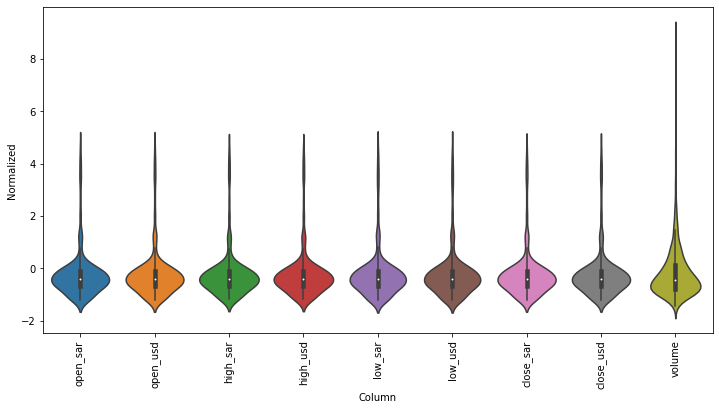

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [17]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
# временной ряд DataFrame и преобразует его в tf.data.Dataset из пар (input_window, label_window) с помощью функции tf.keras.utils.timeseries_dataset_from_array
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result

        return result

    def __repr__(self):
        return '\n'.join([
            f'total window size: {self.total_window_size}',
            f'input indices: {self.input_indices}',
            f'label indices: {self.label_indices}',
            f'label column name(s): {self.label_columns}'])

    def plot(self, model=None, plot_col='unnamed', plot_time='unnamed', max_subplots=3):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]

        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel(plot_time)

In [18]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w1

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [47]
label column name(s): ['close_usd']

In [19]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w2

total window size: 7
input indices: [0 1 2 3 4 5]
label indices: [6]
label column name(s): ['close_usd']

In [20]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('all shapes are: (batch, time, features)')
print(f'window shape: {example_window.shape}')
print(f'inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

all shapes are: (batch, time, features)
window shape: (3, 7, 9)
inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


2022-05-26 19:49:46.457161: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-05-26 19:49:48.026460: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


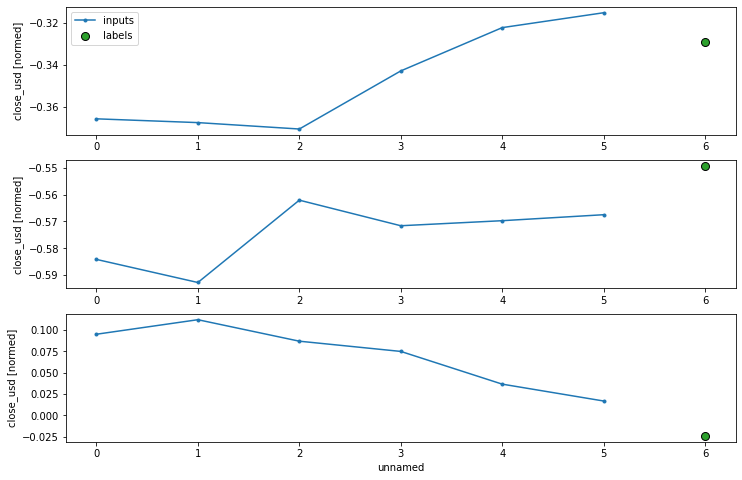

In [21]:
w2.plot(plot_col= my_col_name)

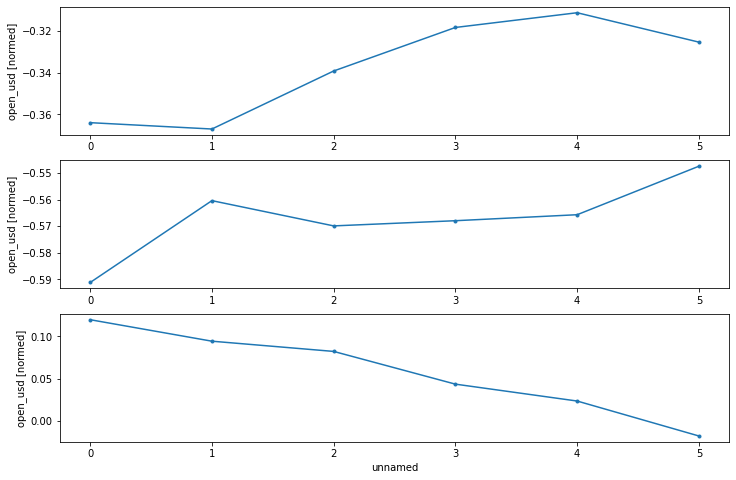

In [22]:
w2.plot(plot_col='open_usd')

In [23]:
w2.train.element_spec #сообщает структуру, типы данных и формы элементов набора данных.

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [24]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 6, 9)
labels shape (batch, time, features): (32, 1, 1)


**ОДНОШАГОВАЯ МОДЕЛЬ**

In [25]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

total window size: 2
input indices: [0]
label indices: [1]
label column name(s): ['close_usd']

In [26]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [27]:
#Базовый уровень
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [28]:
# Создание экземпляра и оценка модели
baseline = Baseline(label_index=column_indices[my_col_name])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
test_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
test_performance['Baseline'] = baseline.evaluate(single_step_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0281


In [29]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window

total window size: 25
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
label column name(s): ['close_usd']

In [30]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


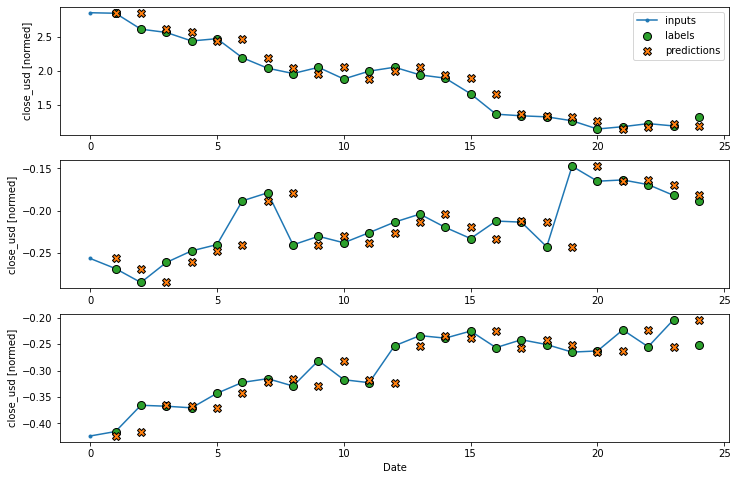

In [31]:
wide_window.plot(baseline, plot_col= my_col_name, plot_time='Date')

**ЛИНЕЙНАЯ МОДЕЛЬ**

In [32]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [33]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [34]:

history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
test_performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
22/22 [==============================] - 1s 13ms/step - loss: 0.6674 - mean_absolute_error: 0.5618 - val_loss: 0.5933 - val_mean_absolute_error: 0.7340
Epoch 2/20
22/22 [==============================] - 0s 8ms/step - loss: 0.4671 - mean_absolute_error: 0.4816 - val_loss: 0.4068 - val_mean_absolute_error: 0.6033
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.3266 - mean_absolute_error: 0.4114 - val_loss: 0.2735 - val_mean_absolute_error: 0.4924
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.2314 - mean_absolute_error: 0.3510 - val_loss: 0.1896 - val_mean_absolute_error: 0.4060
Epoch 5/20
22/22 [==============================] - 0s 8ms/step - loss: 0.1762 - mean_absolute_error: 0.3043 - val_loss: 0.1353 - val_mean_absolute_error: 0.3379
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.1438 - mean_absolute_error: 0.2688 - val_loss: 0.1004 - val_mean_absolute_error: 0.2875
Epoch 7/20
22/22 [=========

In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


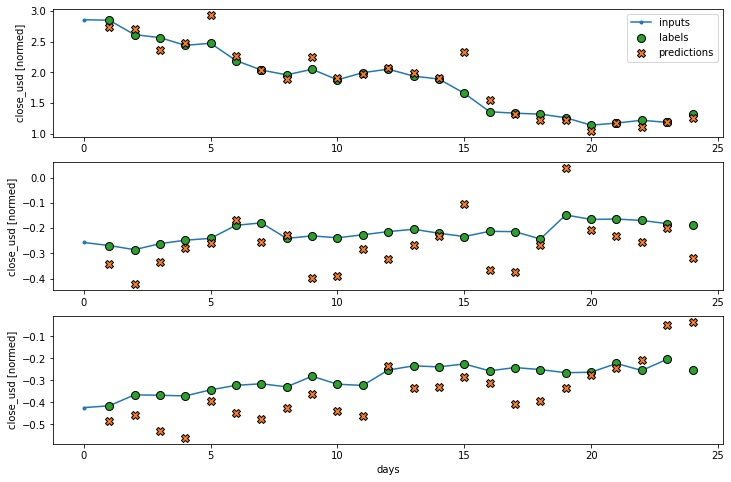

In [36]:
wide_window.plot(linear, plot_col=my_col_name, plot_time=my_time_name)

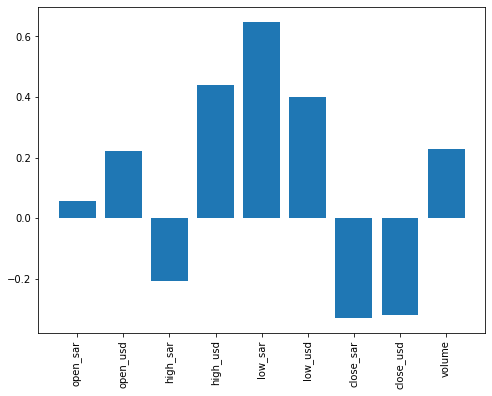

In [37]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

**МОДЕЛЬ DENSE (ПЛОТНАЯ)**

In [38]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
test_performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
22/22 [==============================] - 1s 17ms/step - loss: 0.4334 - mean_absolute_error: 0.3111 - val_loss: 0.0292 - val_mean_absolute_error: 0.1636
Epoch 2/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0212 - mean_absolute_error: 0.0837 - val_loss: 0.0018 - val_mean_absolute_error: 0.0388
Epoch 3/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0085 - mean_absolute_error: 0.0487 - val_loss: 4.5344e-04 - val_mean_absolute_error: 0.0139
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0414 - val_loss: 3.8967e-04 - val_mean_absolute_error: 0.0140
Epoch 5/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0360 - val_loss: 4.8521e-04 - val_mean_absolute_error: 0.0168
Epoch 6/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_absolute_error: 0.0331 - val_loss: 3.4039e-04 - val_mean_absolute_error: 0.0134
Epoch 7/20


In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


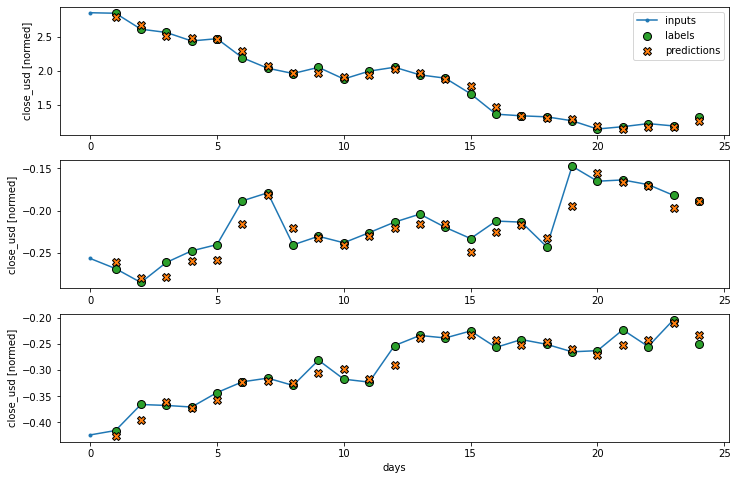

In [40]:
wide_window.plot(dense, plot_col=my_col_name, plot_time=my_time_name)

**МНОГОШАГОВАЯ ПОЛНОСВЯЗАННАЯ МОДЕЛЬ**

In [41]:
conv_window = WindowGenerator(
    input_width=my_conv_width, label_width=1, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
conv_window

total window size: 4
input indices: [0 1 2]
label indices: [3]
label column name(s): ['close_usd']

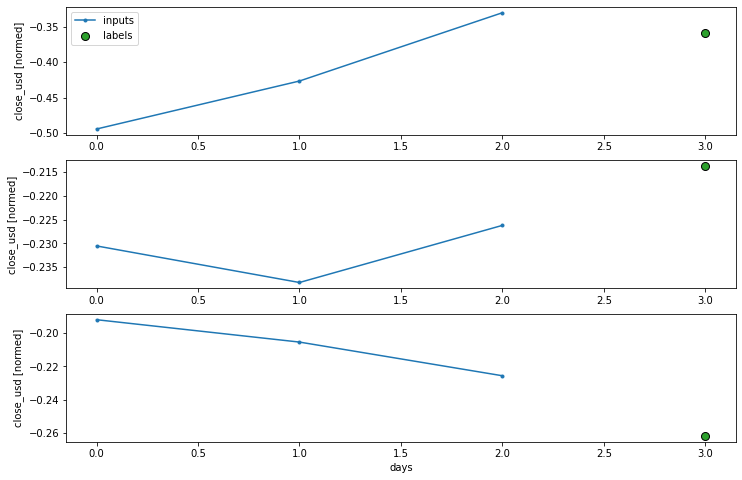

In [42]:
conv_window.plot(plot_col=my_col_name, plot_time=my_time_name)

In [43]:
multi_step_dense = tf.keras.Sequential([
    # shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # add back the time dimension
    # shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [44]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', multi_step_dense(conv_window.example[0]).shape)

input shape: (32, 3, 9)
output shape: (32, 1, 1)


In [45]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['multi_step'] = multi_step_dense.evaluate(conv_window.val)
test_performance['multi_step'] = multi_step_dense.evaluate(conv_window.test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0257


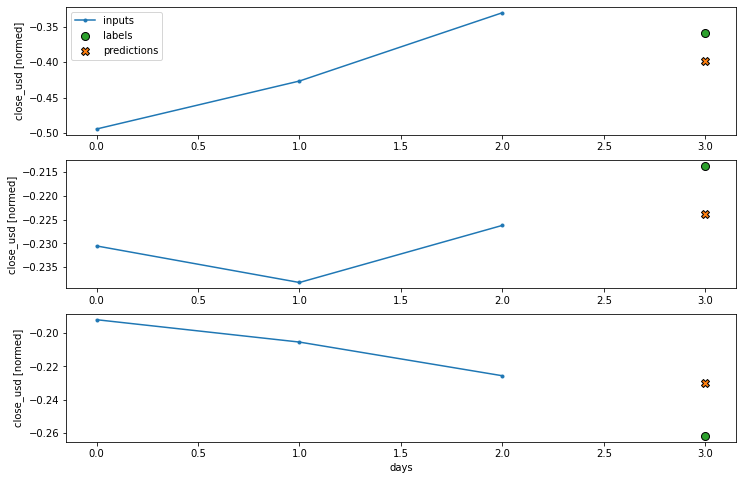

In [46]:
conv_window.plot(multi_step_dense, plot_col=my_col_name, plot_time=my_time_name)

In [47]:
print('input shape:', wide_window.example[0].shape)
try:
    print('output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

input shape: (32, 24, 9)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 27 but received input with shape (32, 216)


**СВЕРТОЧНАЯ СЕТЬ**

In [48]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(my_conv_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [49]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', conv_model(conv_window.example[0]).shape)

input shape: (32, 3, 9)
output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['conv'] = conv_model.evaluate(conv_window.val)
test_performance['conv'] = conv_model.evaluate(conv_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0277


In [51]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [52]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_conv_window

total window size: 27
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
label column name(s): ['close_usd']

In [53]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 9)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


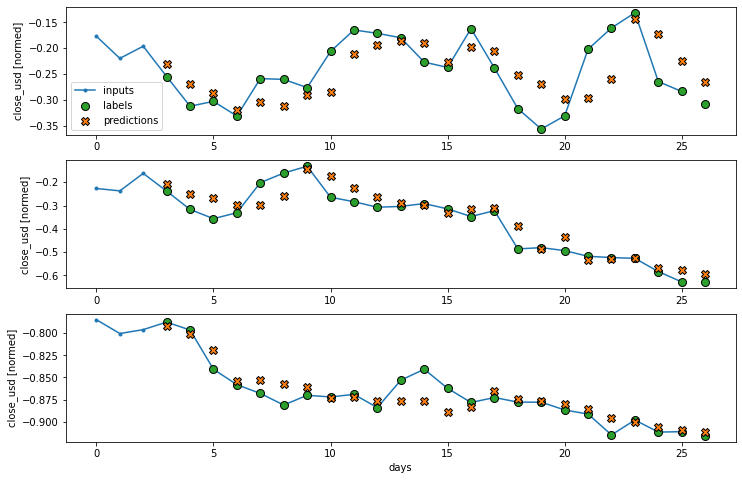

In [54]:
wide_conv_window.plot(conv_model, plot_col=my_col_name, plot_time=my_time_name)

**РЕКУРРЕНТНАЯ СЕТЬ**

In [55]:
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences= True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [56]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', lstm_model(wide_window.example[0]).shape)

input shape: (32, 24, 9)
output shape: (32, 24, 1)


In [57]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
test_performance['lstm'] = lstm_model.evaluate(wide_window.test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_error: 0.0490


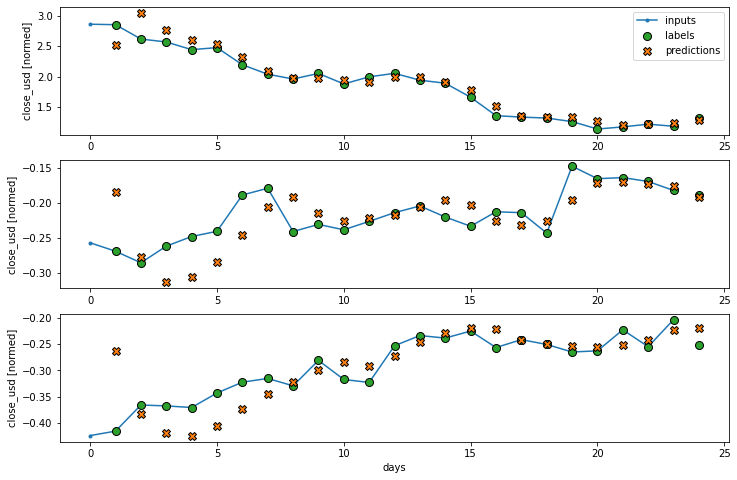

In [58]:
wide_window.plot(lstm_model, plot_col=my_col_name, plot_time=my_time_name)

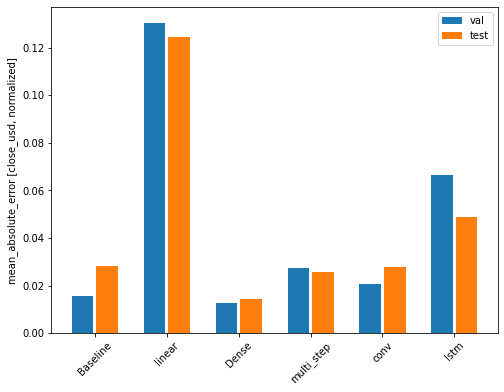

In [59]:
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.ylabel(f'mean_absolute_error [{my_col_name}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance.keys(), rotation=45)
_ = plt.legend()

In [60]:
for name, value in test_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0281
linear      : 0.1246
Dense       : 0.0143
multi_step  : 0.0257
conv        : 0.0277
lstm        : 0.0490


**Модели с несколькими выходами**

In [61]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels
    # if you don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 24, 9)
labels shape (batch, time, features): (32, 24, 9)


базовый уровень

In [62]:
aseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance2['baseline'] = baseline.evaluate(wide_window.val)
test_performance2['baseline'] = baseline.evaluate(wide_window.test)

3/3 [==============================] - 0s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0582


плотный

In [63]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance2['dense'] = dense.evaluate(single_step_window.val)
test_performance2['dense'] = dense.evaluate(single_step_window.test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0486


реккурентная

In [64]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance2['lstm'] = lstm_model.evaluate( wide_window.val)
test_performance2['lstm'] = lstm_model.evaluate( wide_window.test)

3/3 [==============================] - 0s 6ms/step - loss: 0.0156 - mean_absolute_error: 0.0753


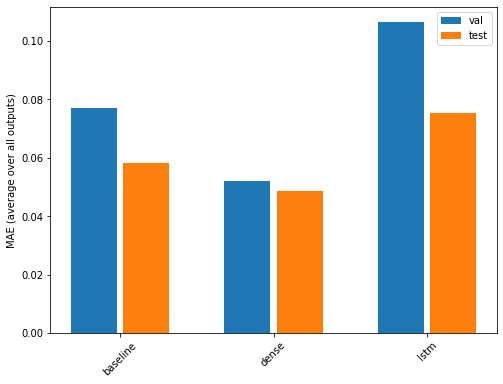

In [65]:
x = np.arange(len(test_performance2))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance2.values()]
test_mae = [v[metric_index] for v in test_performance2.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance2.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [66]:
for name, value in test_performance2.items():
    print(f'{name:15s}: {value[1]:0.4f}')

baseline       : 0.0582
dense          : 0.0486
lstm           : 0.0753


**МНОГОШАГОВЫЕ МОДЕЛИ**

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
label column name(s): None

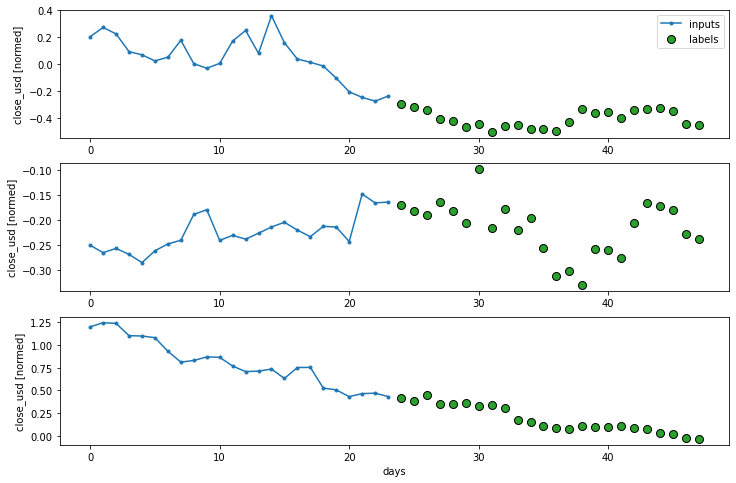

In [67]:
#генерация срезов из набора данных
multi_window = WindowGenerator(input_width=24, label_width=my_out_steps, shift=my_out_steps,
                               train_df=train_df, val_df=val_df, test_df=test_df)
multi_window.plot(plot_col=my_col_name, plot_time=my_time_name)
multi_window

**Базовые данные**

In [68]:
class MultistepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [69]:
last_baseline = MultistepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['last'] = last_baseline.evaluate(multi_window.val)
multi_test_performance['last'] = last_baseline.evaluate(multi_window.test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0256 - mean_absolute_error: 0.1129


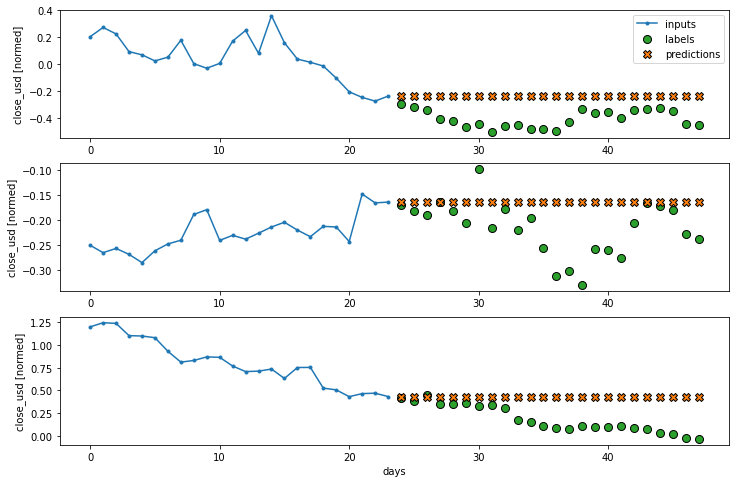

In [70]:
multi_window.plot(last_baseline, plot_col=my_col_name, plot_time=my_time_name)

In [71]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [72]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_test_performance['repeat'] = repeat_baseline.evaluate(multi_window.test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0447 - mean_absolute_error: 0.1767


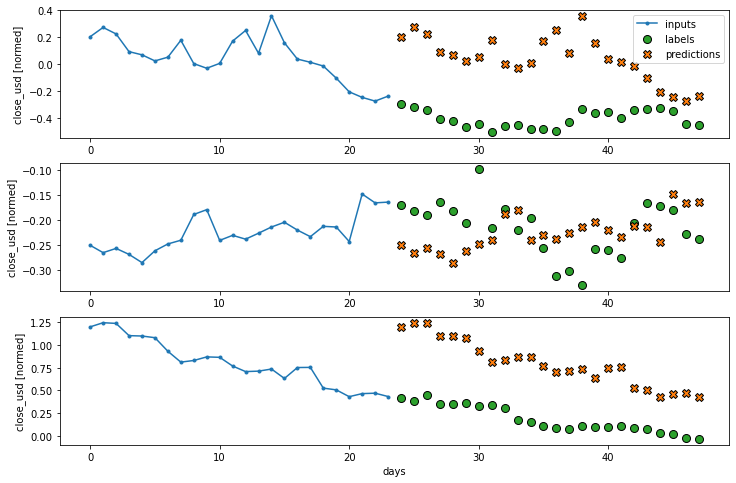

In [73]:
multi_window.plot(repeat_baseline, plot_col=my_col_name, plot_time=my_time_name)

**ЛИНЕЙНАЯ МОДЕЛЬ**

In [74]:
multi_linear_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [75]:
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['linear'] = multi_linear_model.evaluate(multi_window.val)
multi_test_performance['linear'] = multi_linear_model.evaluate(multi_window.test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0442 - mean_absolute_error: 0.1320


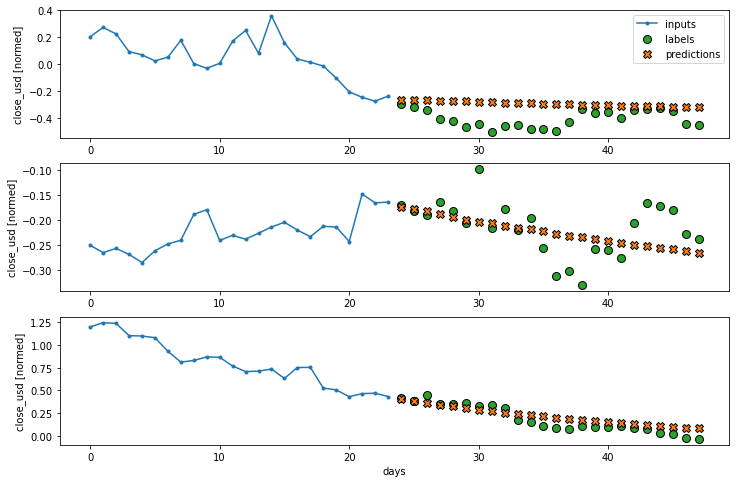

In [76]:
multi_window.plot(multi_linear_model, plot_col=my_col_name, plot_time=my_time_name)

**ПОЛНОСВЯЗАННАЯ МОДЕЛЬ**

In [77]:
multi_dense_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [78]:
history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['dense'] = multi_dense_model.evaluate(multi_window.val)
multi_test_performance['dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

5/5 [==============================] - 0s 2ms/step - loss: 0.0499 - mean_absolute_error: 0.1119


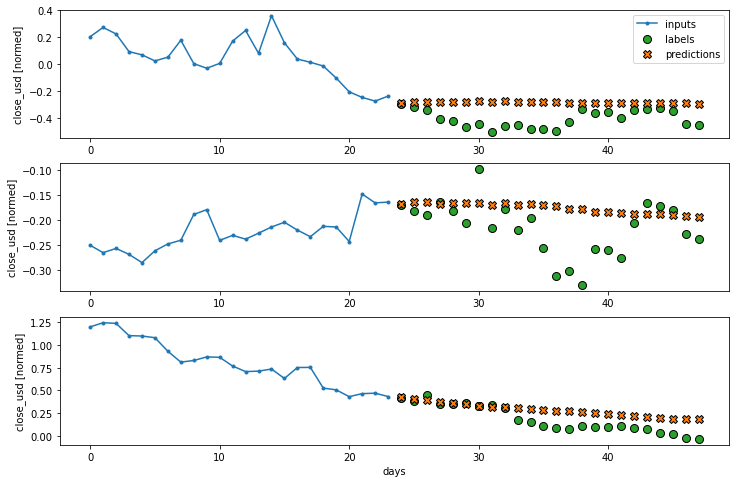

In [79]:
multi_window.plot(multi_dense_model, plot_col=my_col_name, plot_time=my_time_name)

**СВЕРТОЧНАЯ НЕЙРОННАЯ СЕТЬ**

In [80]:
multi_conv_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [81]:
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['conv'] = multi_conv_model.evaluate(multi_window.test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.1331


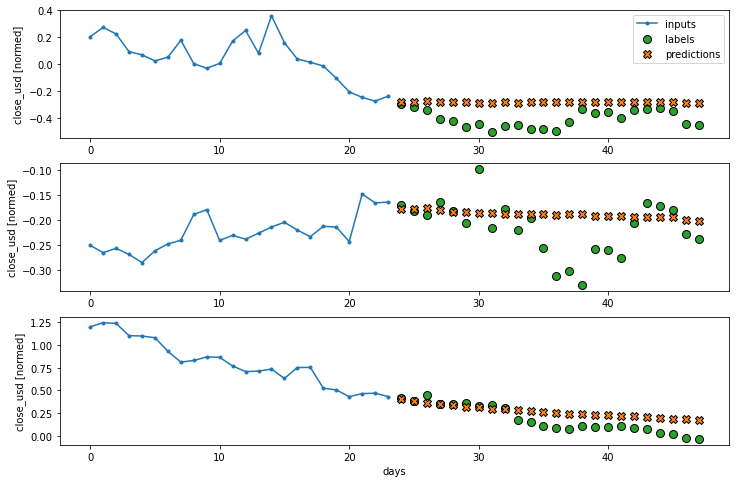

In [82]:
multi_window.plot(multi_conv_model, plot_col=my_col_name, plot_time=my_time_name)

**РЕККУРЕНТНАЯ МОДЕЛЬ**

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [84]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['lstm'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['lstm'] = multi_lstm_model.evaluate(multi_window.test)

2/2 [==============================] - 0s 9ms/step - loss: 0.0284 - mean_absolute_error: 0.1283


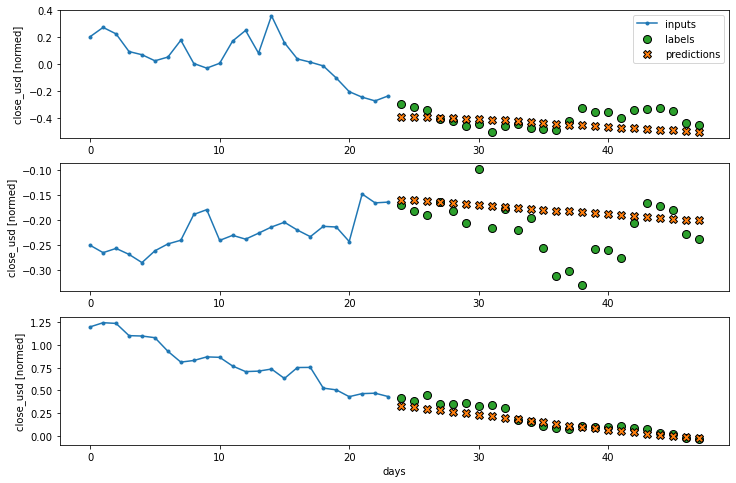

In [85]:
multi_window.plot(multi_lstm_model, plot_col=my_col_name, plot_time=my_time_name)

**АВТОРЕГРЕССИОННАЯ МОДЕЛЬ**

In [86]:
class Feedback(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state,
                                      training=training)

            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [87]:
feedback_model = Feedback(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [88]:
print('output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

output shape (batch, time, features):  (32, 24, 9)


In [89]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()
multi_val_performance['autoregr'] = feedback_model.evaluate(multi_window.val)
multi_test_performance['autoregr'] = feedback_model.evaluate(multi_window.test)

2/2 [==============================] - 0s 10ms/step - loss: 0.0375 - mean_absolute_error: 0.1558


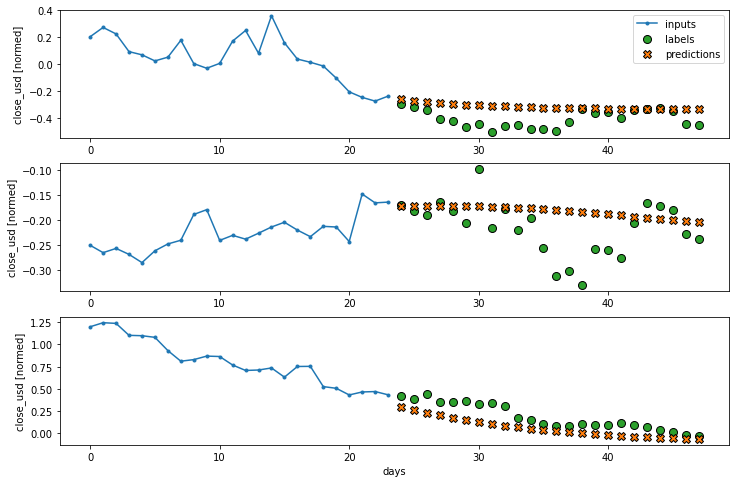

In [90]:
multi_window.plot(feedback_model, plot_col=my_col_name, plot_time=my_time_name)

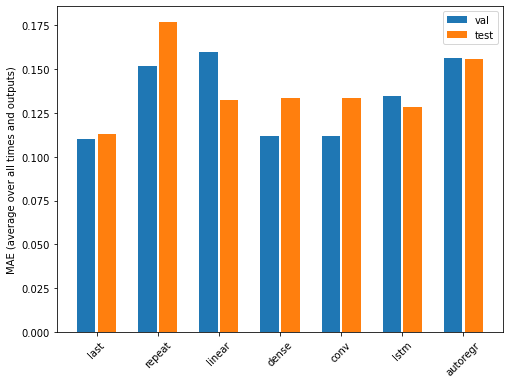

In [91]:
x = np.arange(len(multi_test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [92]:
for name, value in multi_test_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

last    : 0.1129
repeat  : 0.1767
linear  : 0.1320
dense   : 0.1333
conv    : 0.1331
lstm    : 0.1283
autoregr: 0.1558
